In [ ]:
import torch

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
%cd /content

!git clone https://github.com/LinDuoming/LogEval.git
%cd LogEval

!cp static/dataset.zip .
!unzip -o dataset.zip

!pip install -r requirements.txt
!pip install sumy scikit-learn sentence-transformers Levenshtein

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
print("NLTK data downloaded.")

print("\nSetup for Traditional Summarizers complete.")

/content
fatal: destination path 'LogEval' already exists and is not an empty directory.
/content/LogEval
Archive:  dataset.zip
  inflating: dataset/log_anormaly/evaluation_set_chinese_abnormal_detect_few_shot.json  
  inflating: dataset/log_anormaly/evaluation_set_chinese_abnormal_detect_zero_shot.json  
  inflating: dataset/log_anormaly/evaluation_set_english_abnormal_detect_few_shot.json  
  inflating: dataset/log_anormaly/evaluation_set_english_abnormal_detect_zero_shot.json  
  inflating: dataset/log_diagnosis/fault_diagnosis_few_shot_evaluation_set_chinese.json  
  inflating: dataset/log_diagnosis/fault_diagnosis_few_shot_evaluation_set_english.json  
  inflating: dataset/log_diagnosis/fault_diagnosis_zero_shot_evaluation_set_chinese.json  
  inflating: dataset/log_diagnosis/fault_diagnosis_zero_shot_evaluation_set_english.json  
  inflating: dataset/log_parsing/evaluation_set_chinese_log_parsing_few_shot.json  
  inflating: dataset/log_parsing/evaluation_set_chinese_log_parsing_

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
%%writefile run_traditional_summarizers.py
import pandas as pd
import json
import os
import re
import time
import torch
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words


task_file_name_map = {
    "parsing": "log_parsing", "abnormal": "abnormal_detect",
    "diagnose": "fault_diagnosis", "summary": "log_summary"
}
lang_map = {"English": "english", "Chinese": "chinese"}
instr_map = {"zero-shot": "zero_shot", "few-shot": "few_shot"}
task_subfolder_map = {
    "parsing": "log_parsing", "abnormal": "log_anormaly",
    "diagnose": "log_diagnosis", "summary": "log_summary"
}

sbert_model = None
try:
    print("Loading SentenceTransformer model for Cosine Similarity...")
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
    print("SentenceTransformer model loaded.")
except Exception as e:
    print(f"Warning: Could not load SentenceTransformer model for Cosine Similarity: {e}")
    print("Cosine Similarity will not be calculated. Please ensure 'sentence_transformers' is installed and check available RAM.")
    sbert_model = None

def summarize_with_textrank(text, num_sentences=3, lang="english"):
    if not text.strip(): return ""
    parser = PlaintextParser.from_string(text, Tokenizer(lang))
    stemmer = Stemmer(lang)
    summarizer = TextRankSummarizer(stemmer)
    summarizer.stop_words = get_stop_words(lang)

    sentences = [str(sentence) for sentence in summarizer(parser.document, num_sentences)]
    return " ".join(sentences)

def summarize_with_lsa(text, num_sentences=3, lang="english"):
    if not text.strip(): return ""
    parser = PlaintextParser.from_string(text, Tokenizer(lang))
    stemmer = Stemmer(lang)
    summarizer = LsaSummarizer(stemmer)
    summarizer.stop_words = get_stop_words(lang)

    sentences = [str(sentence) for sentence in summarizer(parser.document, num_sentences)]
    return " ".join(sentences)


def _get_dataset(task_type, lang, instr):

    if task_type not in task_file_name_map or lang not in lang_map or instr not in instr_map:
        print(f"Error: Invalid task_type ({task_type}), lang ({lang}) or instr ({instr}) provided.")
        return pd.DataFrame(), {}

    if task_type not in task_subfolder_map:
        print(f"Error: Task subfolder mapping not found for {task_type}. Skipping.")
        return pd.DataFrame(), {}

    if task_type in ["diagnose", "summary"]:
        file_name = f"{task_file_name_map[task_type]}_{instr_map[instr]}_evaluation_set_{lang_map[lang]}.json"
    else:
        file_name = f"evaluation_set_{lang_map[lang]}_{task_file_name_map[task_type]}_{instr_map[instr]}.json"

    file_path = os.path.join("dataset", task_subfolder_map[task_type], file_name)

    print(f"Attempting to load data from: {file_path}")
    print(f"Check existence for this path: {os.path.exists(file_path)}")

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        questions_df = pd.DataFrame(data)

        labels_dict = {row["id"]: row["output"] for _, row in questions_df.iterrows()}
        questions_df['log_entry'] = questions_df['input']

        print(f"Successfully loaded {len(questions_df)} samples for {task_type}, {lang}, {instr}.")
        return questions_df, labels_dict

    except FileNotFoundError:
        print(f"Warning: Data file not found for {task_type} ({lang}, {instr}) at {file_path}. Skipping.")
        return pd.DataFrame(), {}
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format. Skipping.")
        return pd.DataFrame(), {}
    except KeyError as e:
        print(f"Error: Missing expected key in JSON data: {e}. Check data structure. Skipping.")
        return pd.DataFrame(), {}
    except Exception as e:
        print(f"An unexpected error occurred while loading dataset for {task_type} ({lang}, {instr}): {e}. Skipping.")
        return pd.DataFrame(), {}

def calculate_summary_metrics(predict_raw, label_raw):
    predict = predict_raw.strip()
    label = label_raw.strip()

    if not predict and not label:
        return 1.0, 1.0, 1.0
    if not predict or not label:
        return 0.0, 0.0, 0.0

    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(label, predict)
    rouge1_f1 = scores['rouge1'].fmeasure

    cosine_sim_score = 0.0
    if sbert_model is not None:
        try:
            embeddings1 = sbert_model.encode(predict, convert_to_tensor=True)
            embeddings2 = sbert_model.encode(label, convert_to_tensor=True)

            cosine_sim_score = float(util.cos_sim(embeddings1, embeddings2).cpu().numpy())
        except Exception as e:
            print(f"Error computing cosine similarity for summary: {e}. Returning 0.0 for this metric.")
            cosine_sim_score = 0.0

    summary_accuracy = 1.0 if cosine_sim_score >= 0.25 else 0.0

    return summary_accuracy, rouge1_f1, cosine_sim_score


def run_traditional_summarizers():
    results = []

    tasks = ["summary"]
    languages = ["English", "Chinese"]
    instr_types = ["zero-shot", "few-shot"]

    for task_type in tasks:
        for lang in languages:
            for instr in instr_types:
                print(f"\n--- Running Traditional Summarizers for {task_type}, {lang}, {instr} ---")

                dataset_df, labels_dict = _get_dataset(task_type, lang, instr)

                if dataset_df.empty:
                    print(f"No data found for {task_type} ({lang}, {instr}). Skipping.")
                    continue

                all_textrank_f1 = []
                all_textrank_cos_sim = []
                all_lsa_f1 = []
                all_lsa_cos_sim = []


                limited_dataset = dataset_df.head(20)

                for index, row in limited_dataset.iterrows():
                    log_entry = row["log_entry"]
                    ground_truth_label = labels_dict[row["id"]]

                    num_sentences = max(1, len(ground_truth_label.split('.')) // 2)

                    # TextRank
                    predicted_summary_textrank = summarize_with_textrank(log_entry, num_sentences=num_sentences, lang=lang_map[lang])
                    tr_acc, tr_f1, tr_cos_sim = calculate_summary_metrics(predicted_summary_textrank, ground_truth_label)
                    all_textrank_f1.append(tr_f1)
                    all_textrank_cos_sim.append(tr_cos_sim)

                    # LSA
                    predicted_summary_lsa = summarize_with_lsa(log_entry, num_sentences=num_sentences, lang=lang_map[lang])
                    lsa_acc, lsa_f1, lsa_cos_sim = calculate_summary_metrics(predicted_summary_lsa, ground_truth_label)
                    all_lsa_f1.append(lsa_f1)
                    all_lsa_cos_sim.append(lsa_cos_sim)

                avg_textrank_f1 = sum(all_textrank_f1) / len(all_textrank_f1) if all_textrank_f1 else 0
                avg_textrank_cos_sim = sum(all_textrank_cos_sim) / len(all_textrank_cos_sim) if all_textrank_cos_sim else 0
                avg_lsa_f1 = sum(all_lsa_f1) / len(all_lsa_f1) if all_lsa_f1 else 0
                avg_lsa_cos_sim = sum(all_lsa_cos_sim) / len(all_lsa_cos_sim) if all_lsa_cos_sim else 0

                print(f"  --- Traditional Summarizers (Summary Task Only) ---")
                print(f"  Average F1-score (TextRank): {avg_textrank_f1:.4f}")
                print(f"  Average Cosine Similarity (TextRank): {avg_textrank_cos_sim:.4f}")
                print(f"  Average F1-score (LSA): {avg_lsa_f1:.4f}")
                print(f"  Average Cosine Similarity (LSA): {avg_lsa_cos_sim:.4f}")

                results.append({
                    "model": "TextRank (Traditional)",
                    "task": task_type,
                    "lang": lang,
                    "instr": instr,
                    "accuracy": None,
                    "f1_score": avg_textrank_f1,
                    "inference_time": 0.0,
                    "average_tokens": None,
                    "cosine_similarity": avg_textrank_cos_sim,
                })
                results.append({
                    "model": "LSA (Traditional)",
                    "task": task_type,
                    "lang": lang,
                    "instr": instr,
                    "accuracy": None,
                    "f1_score": avg_lsa_f1,
                    "inference_time": 0.0,
                    "average_tokens": None,
                    "cosine_similarity": avg_lsa_cos_sim,
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv("traditional_summarizer_results.csv", index=False)
    print("\nTraditional summarizer results saved to traditional_summarizer_results.csv")

if __name__ == "__main__":
    run_traditional_summarizers()

Overwriting run_traditional_summarizers.py


In [ ]:

%cd /content/LogEval

print("\n--- Running the Traditional Summarizers benchmark ---")
!python run_traditional_summarizers.py

/content/LogEval

--- Running the Traditional Summarizers benchmark ---
2025-07-10 08:28:36.667895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752136116.696751    6425 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752136116.705830    6425 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading SentenceTransformer model for Cosine Similarity...
SentenceTransformer model loaded.

--- Running Traditional Summarizers for summary, English, zero-shot ---
Attempting to load data from: dataset/log_summary/log_summary_zero_shot_evaluation_set_english.json
Check existence for this path: True
Successfully loaded 200 samples for summary, English, zero-shot

Results loaded from traditional_summarizer_results.csv. Shape: (8, 9)

First 5 rows of the results DataFrame:
                    model     task     lang      instr  accuracy  f1_score  \
0  TextRank (Traditional)  summary  English  zero-shot       NaN  0.048788   
1       LSA (Traditional)  summary  English  zero-shot       NaN  0.064114   
2  TextRank (Traditional)  summary  English   few-shot       NaN  0.048788   
3       LSA (Traditional)  summary  English   few-shot       NaN  0.064114   
4  TextRank (Traditional)  summary  Chinese  zero-shot       NaN  0.000000   

   inference_time  average_tokens  cosine_similarity  
0             0.0             NaN           0.474796  
1             0.0             NaN           0.476953  
2             0.0             NaN           0.474796  
3             0.0             NaN           0.476953  
4             0.0             NaN           0.000000  

--- Summary Table of Traditional Summarizers Results ---
                                 

/tmp/ipython-input-21-2964438468.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipython-input-21-2964438468.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


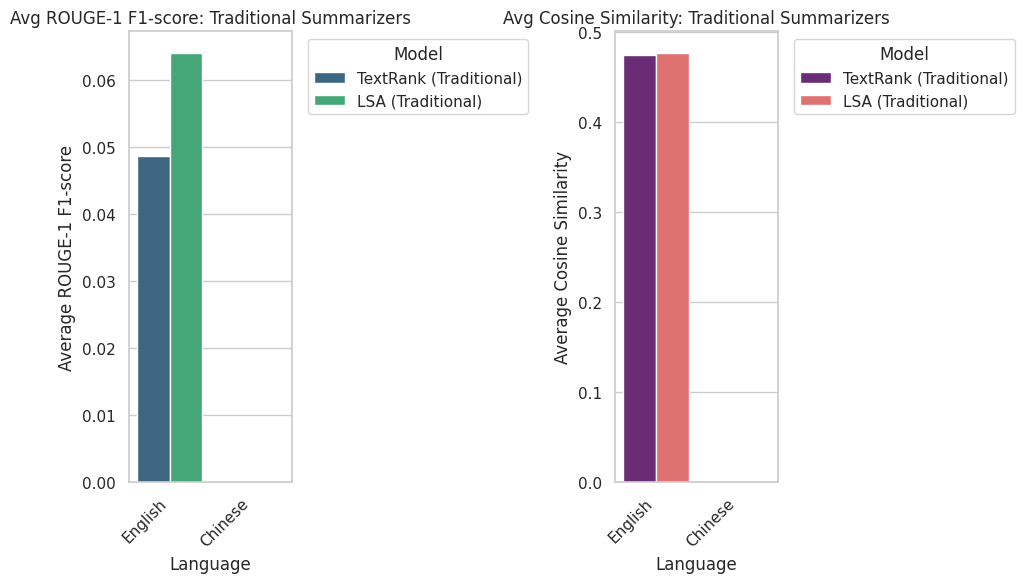


Analysis of Traditional Summarizers complete.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

results_file = "traditional_summarizer_results.csv"
if os.path.exists(results_file):
    df_traditional_results = pd.read_csv(results_file)
    print(f"Results loaded from {results_file}. Shape: {df_traditional_results.shape}")
    print("\nFirst 5 rows of the results DataFrame:")
    print(df_traditional_results.head())
else:
    print(f"Error: {results_file} not found. Please ensure run_traditional_summarizers.py was executed successfully.")
    exit()


print("\n--- Summary Table of Traditional Summarizers Results ---")

summary_pivot_traditional = df_traditional_results.pivot_table(
    index=['model', 'lang', 'instr'],
    values=['f1_score', 'cosine_similarity'],
    aggfunc='mean'
)
print(summary_pivot_traditional)


print("\n--- Generating Visualizations for Traditional Summarizers ---")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))


plt.subplot(1, 2, 1)
sns.barplot(
    data=df_traditional_results,
    x='lang',
    y='f1_score',
    hue='model',
    ci='sd',
    palette='viridis'
)
plt.title('Avg ROUGE-1 F1-score: Traditional Summarizers')
plt.xlabel('Language')
plt.ylabel('Average ROUGE-1 F1-score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.subplot(1, 2, 2)
sns.barplot(
    data=df_traditional_results,
    x='lang',
    y='cosine_similarity',
    hue='model',
    ci='sd',
    palette='magma'
)
plt.title('Avg Cosine Similarity: Traditional Summarizers')
plt.xlabel('Language')
plt.ylabel('Average Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

print("\nAnalysis of Traditional Summarizers complete.")